# Final Project

Our goal in this problem is to practice Kmeans clustering using two methods of initialization: using hierarchical clustering to get k clusters from a subset of the data to start and the other is through random initialization. We will then compare the two different implementaions using adjuster_rand_score(from sklearn). I believe the true k number of clusters will be 4 and that if I compare the different clustering between random initialization and hierarchical , they should have a positive adjusted_rand_score (from sklearn). 

I have played video games almost my entire life (earliest I remember was 7), my drive of competition with my brother pushed me further down that rabbit hole.  In all my time gaming, not once have I ever asked which video games are most closely related to each other? To answer that question we will be working with a videogame dataset that comes from Kaggle(https://www.kaggle.com/ashaheedq/video-games-sales-2019?select=vgsales-12-4-2019.csv) originating from vgchartz.com. The dataset contains data of videogames ranks, genre, ESRB rating (Everyone, Teen, Mature, Etc.), platform, publisher, critics score, user scores, sales (NA-North America, PAL- Europe, JP-Japan, Global) and more. It contains a total of 23 columns and 37102 unique values. It seems to be a fairly large data that will definitely need some data cleaning: as I could already see some columns that will either be not useful or to sparse. Here is each column 

- Rank: Ranking of overall sales
- Name: Name of the game
- BaseName: If two games come out on different platforms (consider merging?)
- Genre: Genre of the game
- ESRB Rating: ESRB Rating of the game
- Platform: (PC, PS4, XBoxOne, Wii,etc.)
- Publisher: of the game
- Developer: of the game
- Critic Score: of game (1-10)
- User Score: of game (1-10)
- Total Shipped: Total shipped copies
- Global_Sales: worldwide sales (in millions)
- NA_Sales: Sales in North America (in millions)
- PAL_Sales: Sales in Europe (in millions)
- JP_Sales: Sales in Japan (in millions)
- Other_Sales: Sales in the rest of the world (in millions)
- Year:Year of release of the game
- VGChartz_Score: empty (full of NaNs)
- Last_Update: when the numbers where last updated
- url: takes to location of game on VGchartz.com
- status: if it is currently available to play (all 1s)
- Vgchartzscore: the score give by VGchartz on the game (sparse)]
- img-url: picture of game from the VGchartz website (dont seem to be live links)


I am going to attempt to cluster this data using **4** of these columns: 'Critic_Score','User_Score','Global_Sales','Year'

I have decided on these columns as they are numeric and have wide range of factors for the game.


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
from sklearn.metrics.cluster import adjusted_rand_score
from IPython.display import display, HTML #for displaying back as nice dfs


### Data Cleaning and Set Up) 

In [2]:
df = pd.read_csv ('vgsales-12-4-2019.csv', encoding= 'UTF-8', header=0) #read data in
#drop nans in all numerical categories

df = df[df['Critic_Score'].notna()]
df = df[df['User_Score'].notna()] #for including user score as a column in kmeans, just reduces amount to 103 vs 1308 when done drop Nans
df = df[df['Year'].notna()]
#df = df[df['Vgchartzscore'].notna()] #--reduces too much
dfDropTotShipped = df[df['Total_Shipped'].notna()] #print(dfDropTotShipped.shape)
df = df[df['Global_Sales'].notna()]
df = df[df['NA_Sales'].notna()] 
df = df[df['PAL_Sales'].notna()]
df = df[df['JP_Sales'].notna()]
df = df[df['Other_Sales'].notna()]
df.drop(columns=['VGChartz_Score', 'url','status','img_url','Last_Update','Total_Shipped'],inplace=True) #drop unnecessary columns,'User_Score'

print(df.shape,dfDropTotShipped.shape)

(103, 17) (64, 23)


Now after cleaning the data and dropping all a NaNs from data we are left with a size of 103 videogames. Lets take a look at a few plots of different columns we will be working on. 

C:\Users\johno\Anaconda3\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\johno\Anaconda3\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


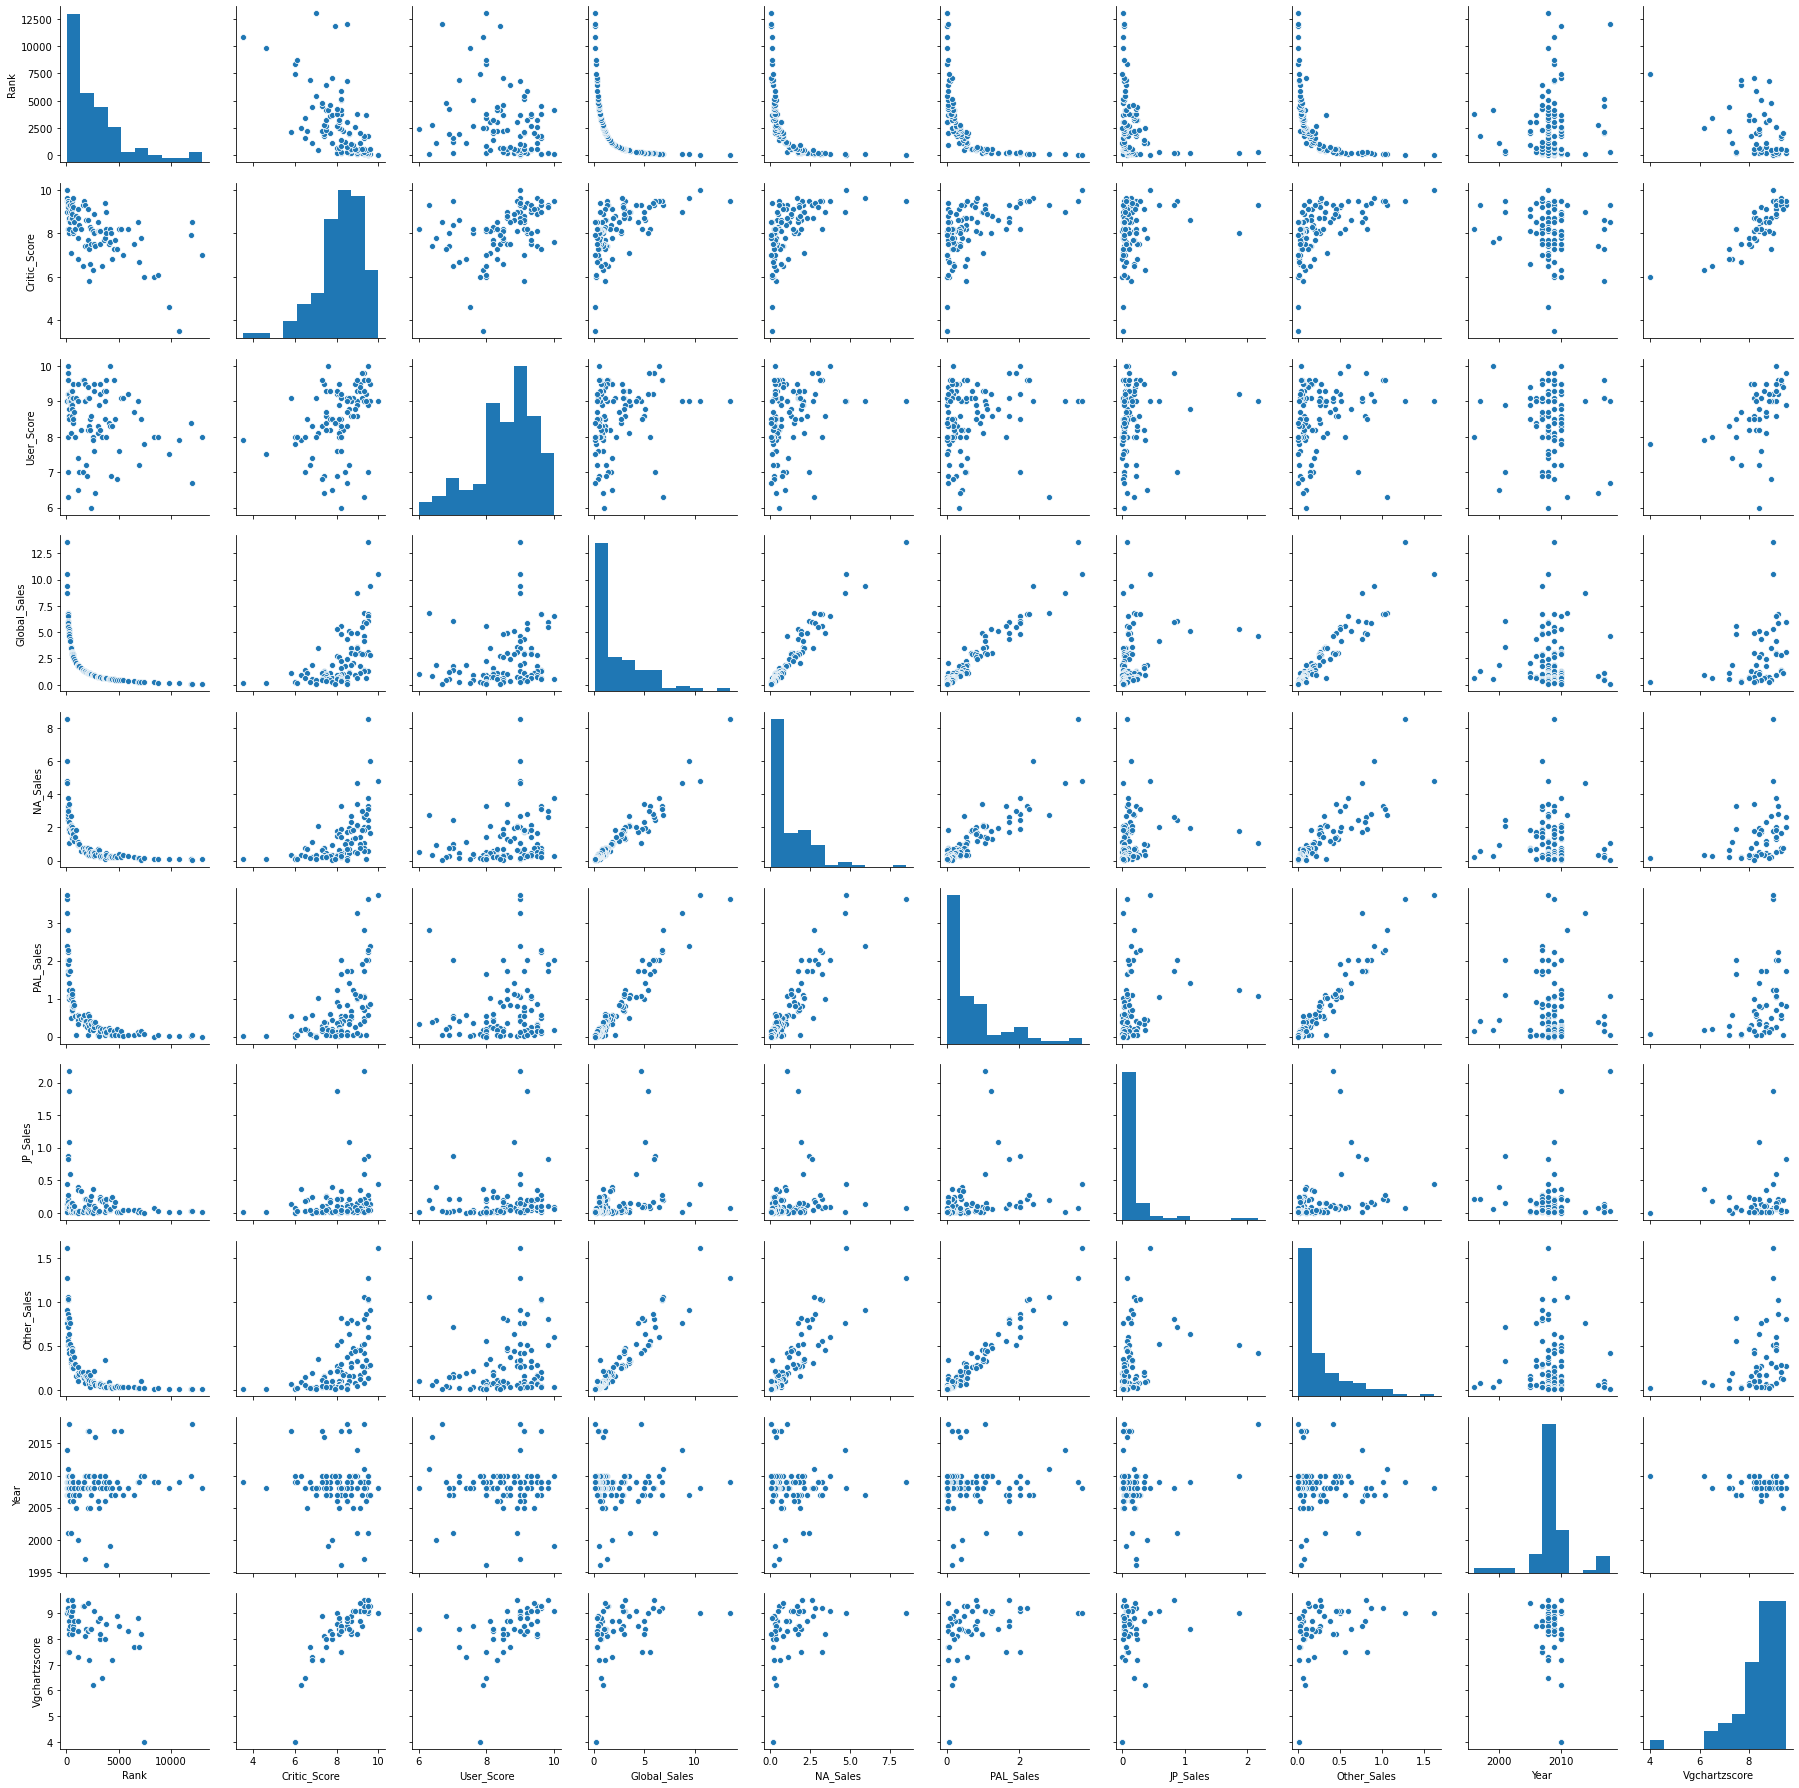

In [3]:
sns.pairplot(df)

In [4]:
df[["Rank", "Critic_Score","User_Score","Global_Sales","NA_Sales","PAL_Sales","JP_Sales","Other_Sales","Year"]].corr()

,Rank,Critic_Score,User_Score,Global_Sales,NA_Sales,PAL_Sales,JP_Sales,Other_Sales,Year
Rank,1.000000,-0.607278,-0.265843,-0.615748,-0.578096,-0.590649,-0.259416,-0.586735,0.138810
Critic_Score,-0.607278,1.000000,0.396112,0.559959,0.534244,0.530167,0.188054,0.562900,-0.094681
User_Score,-0.265843,0.396112,1.000000,0.233842,0.245504,0.183027,0.107102,0.209170,0.020185
Global_Sales,-0.615748,0.559959,0.233842,1.000000,0.963873,0.966676,0.301206,0.943722,-0.004291
NA_Sales,-0.578096,0.534244,0.245504,0.963873,1.000000,0.896334,0.122298,0.859567,-0.037921
PAL_Sales,-0.590649,0.530167,0.183027,0.966676,0.896334,1.000000,0.229090,0.958989,0.022104
JP_Sales,-0.259416,0.188054,0.107102,0.301206,0.122298,0.229090,1.000000,0.271577,0.090718
Other_Sales,-0.586735,0.562900,0.209170,0.943722,0.859567,0.958989,0.271577,1.000000,-0.018532
Year,0.138810,-0.094681,0.020185,-0.004291,-0.037921,0.022104,0.090718,-0.018532,1.000000


So I think the important few things to note which columns have any collinear relationships: 
- first being critic_score and Vgchartzscore have a collinear relationship, if you glance up at the pairplot it will say the same. We will are only including critic score as there is to few scores
- collinear relationship between every sales column except for Japan Sales
    - made me curous to see if that had affect on clustering, would be considered if I had more time to include PCA as I believe this will affect  the final clustering groups
    
    
The decision to focus on just these four columns ['Critic_Score','User_Score','Global_Sales','Year'] comes from the fact the Global Sales are the total of all the sales, seems counter productive to have both in here. 

In [5]:
dfData=df[['Critic_Score','User_Score','Global_Sales','Year']].copy()# ,'User_Score'
print(df['Name']) #was curious to see what games made it to the reduced list that I recognize

49            Call of Duty: Modern Warfare 2
79                       Grand Theft Auto IV
94            Call of Duty 4: Modern Warfare
107                       Grand Theft Auto V
147           Uncharted 3: Drake's Deception
                        ...                 
9824                    Castlevania Judgment
10803           Valhalla Knights: Eldar Saga
11880    BlazBlue: Calamity Trigger Portable
11997             Ys VIII: Lacrimosa of Dana
12995                        Battle Fantasia
Name: Name, Length: 103, dtype: object


#### Normalizing our Data
It turns out as having each category having a wide ranges as units matter with each category on a different scale, it will provide with a more accurate cluster representation. 

In [6]:
dfData.head(3)

,Critic_Score,User_Score,Global_Sales,Year
49,9.5,9.0,13.53,2009.0
79,10.0,9.0,10.57,2008.0
94,9.6,9.0,9.41,2007.0


In [7]:
def norm(df):
    dfData_norm=df.copy()
    #need to normalize data
    means=dfData_norm.mean()
    sd=dfData_norm.std(ddof=1)
    dfData_norm=(dfData_norm-means)/sd
    return dfData_norm #data after normalize
dfData_norm=norm(dfData)
dfData_norm.head(3)

,Critic_Score,User_Score,Global_Sales,Year
49,1.212833,0.524543,4.455947,0.167124
79,1.660582,0.524543,3.279324,-0.115069
94,1.302383,0.524543,2.818215,-0.397263


### Finding K) 
The first thing we will need to do is find the best k to use for our problem. Since Hierarchical initialization is more consistent to start with, we will use this to find our best k by graphing a range from k=2:10(maybe more) by increments of 2 displayed against within-cluster average distance between each data point and its cluster’s centroid

#### Random Init Kmeans
But first lets build both initializations

In [8]:
def printScatter(x,y,df):
    fig, ax= plt.subplots(figsize=(12,6))
    plt.scatter(df[x], df[y])
    ax.set_xlabel(x)
    ax.set_ylabel(y)
def visualize(clusters,df,x,y):
    fig, ax = plt.subplots(figsize=(8,4))
    print("Cluster Assignments: ",clusters)
    plt.scatter(df[x], df[y], c=clusters)
    #plt.scatter([x[0] for x in centroids], [x[1] for x in centroids], c='red', marker='+')
    ax.set_xlabel(x)
    ax.set_ylabel(y);
def dist(x1, x2):
    return np.sqrt(np.sum((x1-x2)**2))
def kMeansRand(K,df,n): #-----------------Kmean implemented with random initialization

    clocs=np.random.choice(range(n), size=K)
    centroids = np.array([df.iloc[clocs[i]] for i in range(K)]) # initialize for any k value
    #print(centroids)
    dists = [0]*K
    clustersn = np.array([-1]*n)
    centroidChange=1#distance btw centroids
    clusterStoppedChanging=False
    while (centroidChange >0) and (not clusterStoppedChanging):# tolerance/change check when I use for comparison with hierarchical clustering
        #update classifications
        prevClustersN=clustersn.copy()
        for j in range(n):
            dists = [dist(df.iloc[j], cent) for cent in centroids]
            assignment = dists.index(min(dists))
            clustersn[j] = assignment
        clustersStoppedChanging= ((prevClustersN==clustersn).all())   
        #update centroids
        prevCentroids= centroids.copy()    
        for j in range(K):
            
            centroids[j]=[np.sum(df.iloc[clustersn==j,z])/len(df.iloc[clustersn==j,z]) for z in range(df.shape[1])]
        
        
        centroidChange = dist(prevCentroids,centroids)
        
    likeR2 = [[] for i in range(K)] #for each centroid avg dist from each point belonging to it
    d=0#  average distance between each data point and its cluster’s centroid
 
    for j in range(n):
        dists = [dist(df.iloc[j], cent) for cent in centroids]
        d+=dists[clustersn[j]]
        likeR2[clustersn[j]].append(dists[clustersn[j]])

    likeR2 = [np.mean(likeR2[i]) if(len(likeR2[i])!=0) else likeR2[i] for i in range(K)]
    d=d/n
   
    return K,clustersn,centroids,likeR2,d

#### Hierarchical Clustering as Initialization) 

But first we are adding some helper functions:

In [9]:
def centroidCalc(X,d):
    centr = [np.nan]*d
    if len(X)==1:
        centr = self.X[0].copy()
    else:
        for d in range(d):
            centr[d] = np.mean([x[d] for x in X])
    return centr
def distanceH(s1,s2,d):
    #print("s1: "+str(s1))
    #print("s2: "+str(s2))
    try:
        s1=centroidCalc(s1,d)
    except:
        s1=s1
    try:
        s2=centroidCalc(s2,d)
    except:
        s2=s2
    distance=dist(np.array(s1),np.array(s2))
    return distance
################sanity check
#X=[[1, 1], [1, 2]]
#T=[1, 1]
#distanceH(T,X,2)

In [10]:
def addSamp(s1,s2):
    t1=np.array(s1)
    t2=np.array(s2)
    #print(s1,s2)
    ans=[]
    try:
        if(t1.shape[1]==1): 
            ans= [s1,s2]
            #print("here_s1_1")
        else:
            try:
                if(t2.shape[1]==1):
                    s1.append(s2)
                    ans=s1
                else:
                    #print("in here",s2)
                    for pt in s2:
                        s1.append(pt)
                        ans=s1
            except: 
                s1.append(s2)
                ans=s1
                #print("s1 mult but s2 single")
    except:
        try:#means s1 is single point
            if(t2.shape[1]==1):
                ans= [s1,s2]
                #print("heres2_1")
            else:
                try:
                    if(t1.shape[1]==1):
                        s2.append(s1)
                        ans=s2
                    else:
                        for pt in s1:
                            s2.append(pt)
                            ans=s2
                except: #s2 mult but s1 single
                    s2.append(s1)
                    ans=s2
                    #print("s2 mult but s1 single")
        except:
            ans= [s1,s2]
            #print("both pts")
    return ans
def addClust(s1,s2):
    t1=type(s1)
    t2=type(s2)
    if(t1==int)and (t2==int):
        ans=[s1,s2]
    elif(t1==int) and (t2!=int):
        s2.append(s1)
        ans=s2
    elif(t1!=int) and (t2==int):
        s1.append(s2)
        ans=s1
    else:
        for pnt in s1:
            s2.append(pnt)
        ans=s2
    
    return ans
#more sanity check tests
#T=[[1, 1], [1, 2]]
#q=[2,4]
#addSamp(q, [1, 3])
#t1=16
#t2=[17,36]
#addClust(t1,t2)

In [11]:
def Hierarchical(df,subSetSize,K,verbose=False,final=True): #runs the initialization for hierachical clustering
    n=subSetSize
    #sub=np.random.choice(range(len(df)), size=n, replace=False)#---defining how to grab subset seemed abstract could do it randomly?
    sub=list(range(n))

    df = df.iloc[sub]

    dim=df.shape[1]

    #group by indexes
    centroids = [i for i in range(n)]#df.iloc[i]
    sampleList= [list(df.iloc[i]) for i in range(n)]
    while(len(sampleList) != K): #until desired k
        
        if(verbose):
            print("Sample sizeBefore: " +str(len(sampleList)))
        #create distance matrix for finding closest two cluster
        Distance_mat = np.zeros((len(centroids),len(centroids)))
        for j in range(len(centroids)):
            for m in range(len(centroids)):
                if j!=m:
                    #print("distanceBtw",sampleList[j]," vs ",sampleList[m])
                    Distance_mat[j,m] = distanceH(sampleList[j],sampleList[m],dim) # dist(np.array(sampleList[j]),np.array(sampleList[m])) 
                else:
                    Distance_mat[j,m] = 10**5
        #_________________________
        
        #find min two centroid distance
        result = np.where(Distance_mat == np.amin(Distance_mat))
        #print("Distance Matrix")
        #print(Distance_mat)
        listOfCordinates = list(zip(result[0], result[1]))
        minCentroidIndices= (-1,-1)
        FirstIt = True
        if(len(listOfCordinates) >=2):
            for cord in listOfCordinates:
                #Distance_mat[cord[0],cord[1]]
                if(FirstIt):
                    FirstIt= False
                    minCentroidIndices= (cord[0],cord[1])
                    minDist= Distance_mat[minCentroidIndices]
                else:
                    if(set(minCentroidIndices) != set((cord[0],cord[1]))):
                        #print(minCentroidIndices)
                        minDist= Distance_mat[minCentroidIndices]
                        other= Distance_mat[cord[0],cord[1]]
                        #print(minCentroidIndices," : ",minDist," vs ",str((cord[0],cord[1]))," : ",other)
                        if(other <minDist):
                            minDist= Distance_mat[cord[0],cord[1]]
                            minCentroidIndices= (cord[0],cord[1])
                            #print("Updated minDist :"+str(minDist)+"Indices: "+str(minCentroidIndices))
            if(verbose):
                print("These two centroids are closest",minCentroidIndices)
        else:
            print(listOfCordinates)
            minCord=listOfCordinates[0]
            minCentroidIndices= (minCord[0],minCord[1])
            minDist= Distance_mat[minCord[0],minCord[1]]
            if(verbose):
                print("List of one!!")
        
        value_to_add      = sampleList.pop(minCentroidIndices[1])
        sampleList[minCentroidIndices[0]]= addSamp(sampleList[minCentroidIndices[0]],value_to_add)#sampleList[minCentroidIndices[0]]+list(value_to_add)#-----------come back here
        if(verbose):
            print('Cluster Node 1:',centroids[minCentroidIndices[0]])
            print('Cluster Node 2:',centroids[minCentroidIndices[1]])
        centroids[minCentroidIndices[0]]=   addClust(centroids[minCentroidIndices[0]],centroids[minCentroidIndices[1]])  
        #centroids[minCentroidIndices[0]].append(centroids[minCentroidIndices[1]])
        #centroids[minCentroidIndices[0]] = [centroids[minCentroidIndices[0]]]
        v = centroids.pop(minCentroidIndices[1])
        if(verbose):
            print('Progression(Current Sample)  :',centroids)
            print('Cluster attained             :',centroids[minCentroidIndices[0]])
            print('Sample size after :',len(sampleList))
            print('')        
    backUplist=list(df.index.values.tolist())
    #convert centroid index back to regular df index
    finalCentroids=centroids.copy()
    for i in range(K):
        centroid= centroids[i]
        if(type(centroid)!=int):
            centroid= [backUplist[centroid[j]] for j in range(len(centroid))]
            finalCentroids[i]=centroid
        else:
            finalCentroids[i]=backUplist[centroid]
    if(final):
        print("After Running Hierarchical Clustering on Subset Here are the clusters: ",finalCentroids)
    #print(centroids)
    #print(backUplist)
    #print(finalCentroids)
    return finalCentroids

In [12]:
def kMeansHierarchical(K,df,n,finalInit=True):
    #initialization
    clustersH=Hierarchical(df,50,K,False,finalInit) #set last variable to True to see iterations of it
    clocs=[]
    for i in range(K):
        cluster=clustersH[i]
        if(type(cluster)!=int):
            choiceI = np.random.choice(range(len(cluster)),size=1)
            choice=cluster[choiceI[0]]
        else:
            choice = cluster
        clocs.append(choice)
    clocs=np.array(clocs)
    ogIndexList=list(dfData_norm.index.values.tolist()) #index list of df with og indexes 
    
    #k means body--------
    centroids = np.array([df.iloc[ogIndexList.index(clocs[i])] for i in range(K)]) # initialize for any k value
    #print(centroids)
    
    dists = [0]*K
    clustersn = np.array([-1]*n)
    centroidChange=1#distance btw centroids
    clusterStoppedChanging=False
    while (centroidChange >0) and (not clusterStoppedChanging): 
        #update classifications
        prevClustersN=clustersn.copy()
        for j in range(n):
            dists = [dist(df.iloc[j], cent) for cent in centroids]
            assignment = dists.index(min(dists))
            clustersn[j] = assignment
        clustersStoppedChanging= ((prevClustersN==clustersn).all())   
        #update centroids
        prevCentroids= centroids.copy()    
        for j in range(K):
            
            centroids[j]=[np.sum(df.iloc[clustersn==j,z])/len(df.iloc[clustersn==j,z]) for z in range(df.shape[1])]
        
        
        centroidChange = dist(prevCentroids,centroids)
        

    likeR2 = [[] for i in range(K)] #for each centroid avg distance to points
    #sums each euclidean distance from cluster point is assigned 
    d=0
    for j in range(n):
        dists = [dist(df.iloc[j], cent) for cent in centroids]
        d+=dists[clustersn[j]]
        likeR2[clustersn[j]].append(dists[clustersn[j]])
        
    d=d/n
    likeR2 = [np.mean(likeR2[i]) if(len(likeR2[i])!=0) else likeR2[i] for i in range(K)]

    #print(likeR2)
    return K,clustersn,centroids,likeR2,d

Running K=  1
Running K=  2
Running K=  3
Running K=  4
Running K=  5
Running K=  6
Running K=  7
Running K=  8
Running K=  9
[1, 2, 3, 4, 5, 6, 7, 8, 9] [1.7566128787615194, 1.4311866197899785, 1.3181691879357376, 1.2511048375588834, 1.1987349724777674, 1.1328815876605474, 1.1152813025127792, 1.0623698009161542, 1.015661866969659]


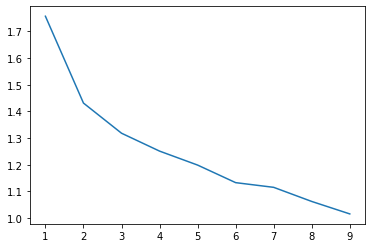

In [13]:
def runForKTimes(dfData_norm,n): #trying to graph the scatter plot not yet complete
    kList=[]
    wccList=[]
    for i in range(1,10,1):
        print("Running K= ",i)
        #print(dfData_norm)
        K,clusters,_,avgDistP_C,d =kMeansHierarchical(i,dfData_norm,n,False)
        kList.append(K)
        #print(np.mean(avgDistP_C),d)
        wccList.append(d)
    return kList,wccList
kList,wccList= runForKTimes(dfData_norm,len(dfData))
print(kList,wccList)
plt.plot(kList, wccList)

So our elbow plot does not look great as there are multiple "elbows", however we also have to consider visually how many clusters it should be. As such 2 groups will not tell us enough so the other elbow, I would argue k is at 3 as when k increases to 4 so does the distance.  

### Lets Compare the two initializations! 

In [14]:
def printAvgDistBtwPtCentroid(lst,val,K):
    print("For each cluster average point to centroid distance: ")
    for i in range(K):
        print("Cluster ",i+1,": ",lst[i])
    print("Avg Point to Centroid Distance overall Clusters: ", val)

Based off of Random Initialization (worse version)
Cluster Assignments:  [1 1 1 1 2 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 2 0 1 2
 1 1 2 2 1 2 2 2 1 1 0 1 2 2 0 1 0 0 0 0 2 0 2 2 0 1 0 2 2 0 2 0 0 0 0 0 0
 1 0 1 2 0 0 0 1 2 0 0 0 2 2 0 0 0 0 0 2 0 0 0 0 0 0 0 2 0]
For each cluster average point to centroid distance: 
Cluster  1 :  1.2257283871766687
Cluster  2 :  1.3454205868499434
Cluster  3 :  1.4781080843659598
Avg Point to Centroid Distance overall Clusters:  1.330891546609981


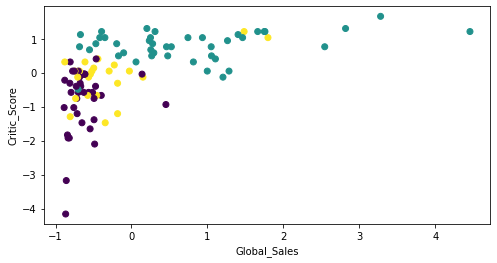

In [15]:
K=3
#for random initializaion one iteration
print("Based off of Random Initialization (worse version)")
_,clusters_rand,_,avgPt_Centr_List_r,avgPt_Centr_r =kMeansRand(K,dfData_norm,len(dfData)) #running k mean with random initialization off the bat wanted to see graph
visualize(clusters_rand,dfData_norm,"Global_Sales","Critic_Score")

printAvgDistBtwPtCentroid(avgPt_Centr_List_r,avgPt_Centr_r,K)

Based off of Hierarchical Initialization
Cluster Assignments:  [0 0 0 0 2 0 0 0 1 0 0 1 0 1 1 1 1 1 0 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 2 2 1 2 1 2 1 1 1 1 2 2 1 1 2 2 2 2 1 1 2 2 2 1 1 2 2 2 1 1 1 2 1 2 1
 1 1 1 1 1 2 1 1 2 2 1 1 2 2 1 1 1 1 1 2 1 2 2 2 2 2 2 2 2]
For each cluster average point to centroid distance: 
Cluster  1 :  1.2808658860740918
Cluster  2 :  1.2874664650282943
Cluster  3 :  1.42482904497348
Avg Point to Centroid Distance overall Clusters:  1.332104536384023


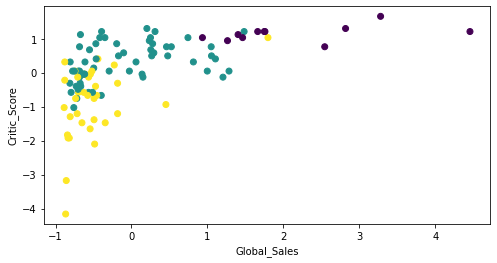

In [16]:
print("Based off of Hierarchical Initialization")
_,clusters_h,_,avgPt_Centr_List_H,avgPt_Centr_H=kMeansHierarchical(K,dfData_norm,len(dfData),False)
visualize(clusters_h,dfData_norm,"Global_Sales","Critic_Score")

printAvgDistBtwPtCentroid(avgPt_Centr_List_H,avgPt_Centr_H,K)

Lets compare with the adjusted rand score from sklearns.

In [17]:
prevRand=adjusted_rand_score(clusters_rand, clusters_h)
print(prevRand)# they are some what similar but not as similar as they could be

0.1741898223451099


In [18]:
df_randomRun100=pd.DataFrame(data=np.zeros((100,len(dfData_norm))))
runsDistList=[] #stores every runs list of avg point to each centroid
runDist=[]
for run in range(100):
    _,clusters_rand,_,avgPt_Centr_List_R,avgPt_Centr_R =kMeansRand(K,dfData_norm,len(dfData))
    df_randomRun100.iloc[run]=clusters_rand
    runsDistList.append(avgPt_Centr_List_R)
    runDist.append(avgPt_Centr_R)
    #print(run,len(clusters_rand))
    if(run % 10 == 0):
        print('run '+str(run))

run 0
run 10
run 20
run 30
run 40
run 50
run 60


C:\Users\johno\Anaconda3\lib\site-packages\ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in double_scalars


run 70
run 80
run 90


In [19]:
sims=np.zeros((100,100)) #similarity matrix
for i in range(100):
    for j in range(100):
        sim=adjusted_rand_score(df_randomRun100.iloc[i], df_randomRun100.iloc[j])
        sims[i,j]=sim
best_run=np.argmax(np.sum(sims, axis=0))
print("Best run out of 100 random kMeans initialization: "+str(best_run))

Best run out of 100 random kMeans initialization: 6


In [20]:
#print(adjusted_rand_score(sims[best_run], clusters_h))
clusters_bestRand=df_randomRun100.iloc[best_run].values
clusters_bestRand=np.array([int(i) for i in clusters_bestRand])
#print(clusters_bestRand,len(clusters_bestRand))
#print(clusters_h)
print("Previous similarity: ",prevRand)
print("For random initialization after selecting most indicative run: ")
print("Now they hold a similarity of: ",adjusted_rand_score(clusters_bestRand, clusters_h))
printAvgDistBtwPtCentroid(runsDistList[best_run],runDist[best_run],K)
print("Same Hierarchical initialization as before:")
printAvgDistBtwPtCentroid(avgPt_Centr_List_H,avgPt_Centr_H,K)

Previous similarity:  0.1741898223451099
For random initialization after selecting most indicative run: 
Now they hold a similarity of:  0.4723673248517922
For each cluster average point to centroid distance: 
Cluster  1 :  1.4906296459144464
Cluster  2 :  1.342531286609557
Cluster  3 :  1.1644167812245667
Avg Point to Centroid Distance overall Clusters:  1.3038468349210446
Same Hierarchical initialization as before:
For each cluster average point to centroid distance: 
Cluster  1 :  1.2808658860740918
Cluster  2 :  1.2874664650282943
Cluster  3 :  1.42482904497348
Avg Point to Centroid Distance overall Clusters:  1.332104536384023


**Now to decide which Kmeans initialization was better**

There similiarity score between the two initialization have increased, however looking at the average distance from point to there respective centroid random initialization is slighltly better than Hierarchical initialization. 

Cluster Assignments:  [0 0 0 0 2 0 0 0 1 0 0 1 0 1 1 1 1 1 0 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 2 2 1 2 1 2 1 1 1 1 2 2 1 1 2 2 2 2 1 1 2 2 2 1 1 2 2 2 1 1 1 2 1 2 1
 1 1 1 1 1 2 1 1 2 2 1 1 2 2 1 1 1 1 1 2 1 2 2 2 2 2 2 2 2]


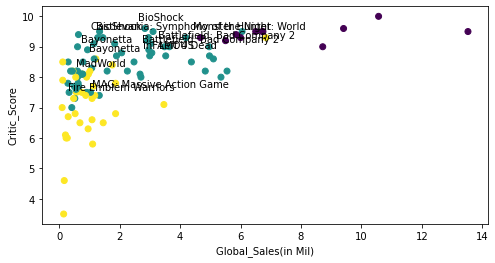

In [21]:
#reducing amount of names displayed on final cluster representation
reducedNameList=list(df.loc[df['Rank'] <= 5000]['Name'].values)

gameNames=list(df['Name'].values)
nameIndex=np.random.choice(range(len(gameNames)),size=10,replace=False)
#nameIndex= list(range(1,len(gameNames),3))
#dropNameList=[ gameNames[index] for index in nameIndex]
#gameNames_reduced=[name if ((name not in dropNameList)and(gameNames.index(name)%3!=0 and (gameNames.index(name)%4!=0))) else "" for name in gameNames]
keepNameList=[gameNames[index] for index in nameIndex]
gameNames_reduced=[name if (name in keepNameList) else "" for name in gameNames]
fig, ax = plt.subplots(figsize=(8,4))
print("Cluster Assignments: ",clusters_h)
plt.scatter(df["Global_Sales"], df["Critic_Score"], c=clusters_h)
#plt.scatter([x[0] for x in centroids], [x[1] for x in centroids], c='red', marker='+')
for x_pos, y_pos, label in zip(df["Global_Sales"],  df["Critic_Score"], gameNames_reduced):
    ax.annotate(label,xy=(x_pos, y_pos),xytext=(-7, 8),textcoords='offset points',ha='left')
ax.set_xlabel("Global_Sales(in Mil)")
ax.set_ylabel("Critic_Score");

The graph still looks hard to read even with only a few videogame names listed next to their points, lets print the final clusters again without the names

Cluster Assignments:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 1
 2 2 1 1 2 1 1 1 2 2 2 2 1 1 2 2 1 1 1 1 1 1 1 1 1 2 2 1 1 1 2 2 2 1 2 1 2
 2 1 2 1 2 1 1 2 1 1 2 1 1 1 2 1 2 1 2 1 1 1 1 1 1 1 1 1 1]
For each cluster average point to centroid distance: 
Cluster  1 :  1.4906296459144464
Cluster  2 :  1.342531286609557
Cluster  3 :  1.1644167812245667
Avg Point to Centroid Distance overall Clusters:  1.3038468349210446


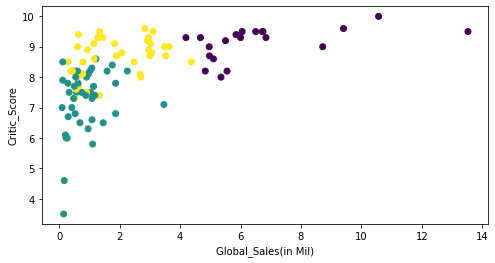

In [30]:
def displayFinalVis(clusters):
    fig, ax = plt.subplots(figsize=(8,4))
    print("Cluster Assignments: ",clusters)
    plt.scatter(df["Global_Sales"], df["Critic_Score"], c=clusters)
    #plt.scatter([x[0] for x in centroids], [x[1] for x in centroids], c='red', marker='+')
    ax.set_xlabel("Global_Sales(in Mil)")
    ax.set_ylabel("Critic_Score");
displayFinalVis(clusters_bestRand)
printAvgDistBtwPtCentroid(runsDistList[best_run],runDist[best_run],K)

**That looks better, but lets actually look at which videogames made each cluster**

In [37]:
def printClusters(clusters,displayLevel):
    ClusterList=[pd.DataFrame() for c in range(K)]
    platformList=list(df['Platform'].values)
    GenreList=list(df['Genre'].values)

    for i in range(len(gameNames)):
        name=gameNames[i]
        row=df.loc[((df['Name'] == name) & (df["Platform"]==platformList[i]))]
        ClusterList[clusters[i]]=ClusterList[clusters[i]].append(row)
    displayName=['Name', 'Platform']
    displayList=['Name', 'Genre', 'ESRB_Rating', 'Platform']#, 'Rank'
    displayList_fullView=['Name', 'Rank', 'Genre', 'ESRB_Rating', 'Platform','Publisher', 'Developer']
    displayList_fullView_data=['Name','Critic_Score', 'User_Score', 'Global_Sales', 'Year' ]
    displayList_full=['Name', 'Rank', 'Genre', 'ESRB_Rating', 'Platform','Publisher', 'Developer','Critic_Score', 'User_Score', 'Global_Sales', 'Year']
    if(displayLevel==0):
        d=displayName
    if(displayLevel==1):
        d=displayList
    if(displayLevel==2):
        d=displayList_fullView
    if(displayLevel==3):
        d=displayList_fullView_data
    if(displayLevel==4):
        d=displayList_full
    for c in range(K):
        print("For cluster "+str(c+1)+": ")
        dfTemp=ClusterList[c][d]
        display(HTML(dfTemp.to_html()))
printClusters(clusters_bestRand,3)

For cluster 1: 


,Name,Critic_Score,User_Score,Global_Sales,Year
49,Call of Duty: Modern Warfare 2,9.5,9.0,13.53,2009.0
79,Grand Theft Auto IV,10.0,9.0,10.57,2008.0
94,Call of Duty 4: Modern Warfare,9.6,9.0,9.41,2007.0
107,Grand Theft Auto V,9.0,9.0,8.72,2014.0
147,Uncharted 3: Drake's Deception,9.3,6.3,6.84,2011.0
151,Uncharted 2: Among Thieves,9.5,9.6,6.74,2009.0
152,Call of Duty 4: Modern Warfare,9.5,9.6,6.72,2007.0
160,Red Dead Redemption,9.5,10.0,6.50,2010.0
176,Metal Gear Solid 2: Sons of Liberty,9.5,7.0,6.05,2001.0
180,Metal Gear Solid 4: Guns of the Patriots,9.3,9.8,6.00,2008.0


For cluster 2: 


,Name,Critic_Score,User_Score,Global_Sales,Year
462,Guitar Hero: On Tour,7.1,8.1,3.46,2008.0
857,Guitar Hero III: Legends of Rock,8.2,8.0,2.25,2007.0
1104,Star Wars: The Force Unleashed,6.8,7.4,1.86,2008.0
1110,The Legend of Dragoon,7.8,6.5,1.86,2000.0
1198,Crackdown,8.4,7.0,1.75,2007.0
1381,Devil May Cry 4,8.2,8.2,1.58,2008.0
1562,The House of the Dead 2 & 3 Return,6.5,7.0,1.45,2008.0
1915,Bayonetta,8.6,7.2,1.21,2010.0
2001,Army of Two,7.4,6.9,1.17,2008.0
2081,Mirror's Edge,7.7,8.2,1.13,2008.0


For cluster 3: 


,Name,Critic_Score,User_Score,Global_Sales,Year
320,Resistance: Fall of Man,8.5,9.1,4.37,2006.0
419,Jak and Daxter: The Precursor Legacy,9.0,8.9,3.64,2001.0
449,Left 4 Dead,8.7,9.0,3.52,2008.0
458,Battlefield: Bad Company 2,9.0,9.3,3.48,2010.0
537,Mass Effect 2,9.5,8.9,3.10,2010.0
545,Heavy Rain,8.8,8.6,3.06,2010.0
559,Killzone 2,9.1,9.3,3.02,2009.0
572,inFAMOUS,8.7,9.1,2.99,2009.0
580,Battlefield: Bad Company 2,8.9,8.8,2.96,2010.0
583,Street Fighter IV,9.3,9.3,2.95,2009.0


Above display all the clusters!!!